In [8]:
import pandas as pd
import os

# 현재 파이썬 코드의 파일 경로
current_path = os.getcwd()  # 현재 작업 디렉토리를 가져옵니다.

# CSV 파일 경로
file_path = os.path.join(current_path, 'sample.csv')  # User uploaded fioytle to this path

df = pd.read_csv(file_path)
df

,note_id,person_id,age,gender_source_value,BMI,admission_department,division,ward,asa_class,surgeon_id,...,condition_source_value,surgery_room,previous_surgery,emergency_status,op_timing,day_of_the_week,week_of_the_month,month,surgeon_estimated_op_time,surgery_duration
0,101058,29,81,F,25.247087,General Surgery,Admission,NUGW2,2,9885,...,D00002196,203,N,N,TF2,Thursday,4,October,130,66
1,57801,64,60,F,24.376249,Otolaryngology,Admission,102,2,6194,...,D00003798,504,N,N,8A,Friday,2,January,300,130
2,71288,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF4,Monday,4,April,100,85
3,135104,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF2,Monday,3,August,100,83
4,221210,71,94,M,27.963140,Orthopedics,Admission,41,2,29473,...,D00018711,108,N,N,TF4,Monday,5,March,100,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9925,279013,159456,81,F,28.122504,Ophthalmology,Day,81,3,30791,...,D00008676,502,Y,N,TF6,Monday,2,May,100,39
9926,155560,159476,52,M,23.513764,Plastic Surgery,Admission,65,1,11896,...,D00004826,503,N,N,8A,Wednesday,4,November,100,82
9927,158720,159482,65,M,25.781926,Ophthalmology,Admission,81,2,30791,...,D00008938,501,N,N,TF1,Monday,5,March,130,61
9928,105781,159493,69,F,25.695245,Orthopedics,Admission,42,3,28695,...,D00012919,106,N,N,TF2,Tuesday,1,December,200,130


In [9]:
# Correcting the column to 'surgical_department'
adult_depts_corrected = df[~df['surgical_department'].str.startswith('Pediatric')]
pediatric_depts_corrected = df[df['surgical_department'].str.startswith('Pediatric')]

# Counting the number of df entries for each category in the corrected column
adult_dept_count_corrected = adult_depts_corrected['surgical_department'].value_counts()
pediatric_dept_count_corrected = pediatric_depts_corrected['surgical_department'].value_counts()

adult_dept_count_corrected, pediatric_dept_count_corrected

(surgical_department
 Ophthalmology                      2586
 General Surgery                    2343
 Orthopedics                        1498
 Urology                             939
 Cardiovascular Thoracic Surgery     689
 Otolaryngology                      665
 Plastic Surgery                     455
 Obstetrics & Gynecology             407
 Neurosurgery                        348
 Name: count, dtype: int64,
 Series([], Name: count, dtype: int64))

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 특정 컬럼의 분리 및 제거:
# 먼저 note_id, person_id, surgeon_estimated_op_time, final_op_name 컬럼을 데이터셋에서 제거합니다. 
# 이 컬럼들은 모델링에 필요하지 않거나 예측에 도움이 되지 않는 정보를 포함할 수 있습니다.
# Specific columns separation and removal
note_id = df['note_id']
person_id = df['person_id']
surgeon_estimated_op_time = df['surgeon_estimated_op_time']
df.drop(columns=['note_id', 'person_id', 'surgeon_estimated_op_time', 'final_op_name'], inplace=True)

# 범주형 데이터 인코딩:
# 범주형 데이터를 숫자로 변환하기 위해 인코딩을 수행합니다.
# 이진 인코딩(Binary Encoding), 원-핫 인코딩(One-Hot Encoding)
# Encoding categorical data
binary_cols = ['condition_source_value', 'op_code', 'surgeon_id', 'ward', 'admission_department', 'surgery_room']
for col in binary_cols:
    df[col] = df[col].astype('category').cat.codes

one_hot_cols = ['surgical_department', 'op_timing', 'month', 'anesthesia_type', 
                'day_of_the_week', 'asa_class', 'week_of_the_month', 
                'division', 'previous_surgery', 'emergency_status', 'gender_source_value']
df_encoded = pd.get_dummies(df, columns=one_hot_cols)

# 데이터 분할:
# X_all: 모델링에 사용할 모든 특성(features)을 포함합니다. surgery_duration을 제외한 모든 컬럼을 포함합니다.
# y_all: 예측하고자 하는 목표 변수(target variable), 즉 surgery_duration입니다.
# train_test_split: 데이터셋을 훈련 세트와 테스트 세트로 분할합니다. 일반적으로 80%의 데이터를 훈련에, 나머지 20%는 모델 성능 평가에 사용합니다. random_state=42를 설정하여 분할이 재현 가능하도록 합니다.
# Data splitting
X_all = df_encoded.drop("surgery_duration", axis=1)
y_all = df_encoded["surgery_duration"]
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Displaying the first few rows of the resulting dataframe
X_train_all.head(), y_train_all.head()


(      age        BMI  admission_department  ward  surgeon_id  op_code  \
 7750   50  14.901935                     8     1          20      752   
 2291   86  21.258289                    11    31         101      508   
 6220   69  22.723853                    13     0          20      203   
 7403   64  26.010848                     9    23          12      132   
 5805   89  33.421514                    11    31         101      508   
 
       condition_source_value  surgery_room  \
 7750                    1346            25   
 2291                     266            23   
 6220                     691            15   
 7403                     639            29   
 5805                     441            23   
 
       surgical_department_Cardiovascular Thoracic Surgery  \
 7750                                              False     
 2291                                              False     
 6220                                              False     
 7403                 

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 분과별 데이터셋 준비
departments = df['surgical_department'].unique()
models = {}
predictions = {}

# 각 분과별 모델 훈련
for dept in departments:
    # 열 이름 조정
    dept_col_name = 'surgical_department_' + dept

    # 분과별 데이터 필터링
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery_duration', axis=1)
    y_dept = dept_data['surgery_duration']

    # 데이터 분할
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # 모델 훈련 (랜덤 포레스트 예시)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_dept, y_train_dept)
    models[dept] = model

    # 테스트 데이터셋에 대한 예측 수행
    predictions[dept] = model.predict(X_test_dept)

# 앙상블을 위한 준비
final_predictions = np.zeros(len(X_test_all))
test_indices = X_test_all.index

# 각 분과별 모델을 전체 테스트 데이터셋에 적용
for dept, model in models.items():
    # 열 이름 조정
    dept_col_name = 'surgical_department_' + dept

    # 해당 분과에 해당하는 테스트 데이터 인덱스
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index

    # 해당 분과의 예측값 계산
    dept_predictions = model.predict(X_test_all.loc[dept_indices])

    # 최종 예측 배열에 해당 부분 업데이트
    final_predictions[np.isin(test_indices, dept_indices)] = dept_predictions

# 성능 평가
mae = mean_absolute_error(y_test_all, final_predictions)
rmse = np.sqrt(mean_squared_error(y_test_all, final_predictions))
r2 = r2_score(y_test_all, final_predictions)

print(f"Ensemble MAE: {mae}, RMSE: {rmse}, R²: {r2}")

Ensemble MAE: 16.544195955018463, RMSE: 34.954576071973634, R²: 0.8840703942884882


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# 그리드 서치 객체 생성
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)

# 그리드 서치 수행
grid_search.fit(X_train_all, y_train_all)

# 최적의 하이퍼파라미터 출력
print(grid_search.best_params_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 200}


In [15]:
# 최적의 하이퍼파라미터 조합
best_params = grid_search.best_params_
print(f"최적의 하이퍼파라미터 조합: {best_params}")

# 최적의 성능 지표 (예: 평균 제곱 오차)
best_score = grid_search.best_score_
print(f"최적의 성능 지표: {best_score}")

최적의 하이퍼파라미터 조합: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 200}
최적의 성능 지표: 0.6784173683902909


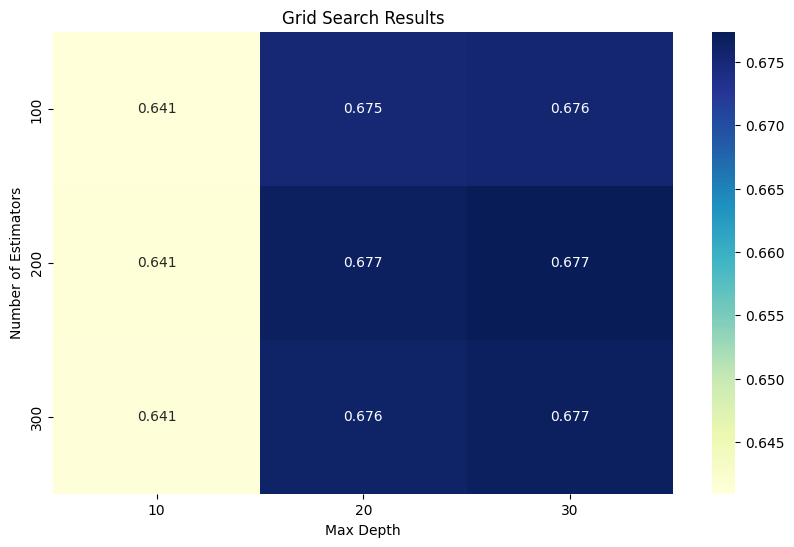

In [14]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# 그리드 서치 결과를 DataFrame으로 변환
results = pd.DataFrame(grid_search.cv_results_)
heatmap_data = results.pivot_table(values='mean_test_score', index='param_n_estimators', columns='param_max_depth')

# 히트맵 생성
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Grid Search Results")
plt.ylabel("Number of Estimators")
plt.xlabel("Max Depth")
plt.show()